In [32]:
import jax
import jax.numpy as jnp
import numpy as np

In [33]:
# state: x = [v, w], param: lambda
ep, a, b = 0.08, 0.7, 0.8
def drift(x, lam):
    v, w = x[0], x[1]
    I = lam[0] # I(t), but here we assume it's a fixed input
    dvdt = v - (v**3) / 3 - w + I
    dwdt = ep * (v + a - b * w)
    return jnp.array([dvdt, dwdt])

def closed_mu_dot(mu, lam, Sigma, Lambda, C):
    f_mu = drift(mu, lam)

    # jacobian and hessian computations
    Jx = jax.jacfwd(drift, argnums=0)(mu, lam)
    Hxx = jax.hessian(drift, argnums=0)(mu, lam)
    Hll = jax.hessian(drift, argnums=1)(mu, lam)
    Hxl = jax.jacfwd(jax.grad(drift, argnums=0), argnums=1)(mu, lam)

    # trace computations
    tr_Hxx_Sigma = jnp.array([jnp.trace(Hxx[i] @ Sigma) for i in range(2)])
    tr_Hll_Lambda = jnp.array([jnp.trace(Hll[i] @ Lambda) for i in range(2)])
    # tr_Hxl_C = jnp.array([jnp.trace(Hxl[i] @ C) for i in range(2)])
    tr_Hxl_C = jnp.array([jnp.dot(Hxl[i].ravel(), C.ravel()) for i in range(2)])

    dmu = f_mu + 0.5 * tr_Hxx_Sigma + 0.5 * tr_Hll_Lambda + tr_Hxl_C
    return dmu

def closed_sigma_dot(Jx, Sigma, noise_cov):
    return Jx @ Sigma + Sigma @ Jx.T + noise_cov

def closed_cross_cov_dot(Jx, Jlam, C, Lambda):
    return Jx @ C + Jlam @ Lambda

In [34]:
def flatten_state(mu, Sigma, C):
    return jnp.concatenate([
        mu.ravel(),
        Sigma.ravel(),
        C.ravel()
    ])

def unflatten_state(z):
    mu = z[0:2]
    Sigma = z[2:6].reshape(2, 2)
    C = z[6:8].reshape(2, 1)
    return mu, Sigma, C

In [ ]:
@jax.jit
def moment_rhs(t, z, args):
    lam, Lambda, noise_cov = args
    mu, Sigma, C = unflatten_state(z)

    # drift and jacobians

    # see if we can replace Jx with the expectation of 
    Jx = jax.jacfwd(drift, argnums=0)(mu, lam)
    Jlam = jax.jacfwd(drift, argnums=1)(mu, lam)

    # mu
    Hxx = jax.hessian(drift, argnums=0)(mu, lam)
    Hll = jax.hessian(drift, argnums=1)(mu, lam)
    Hxl = jax.jacfwd(jax.jacfwd(drift, argnums=0), argnums=1)(mu, lam)

    f_mu = drift(mu, lam)

    tr_Hxx_Sigma = 0.5 * jnp.array([jnp.trace(Hxx[i] @ Sigma) for i in range(mu.shape[0])])
    tr_Hll_Lambda = 0.5 * jnp.array([jnp.trace(Hll[i] @ Lambda) for i in range(mu.shape[0])])
    tr_Hxl_C = jnp.einsum('ijk,jk->i', Hxl, C)

    dmu = f_mu + tr_Hxx_Sigma + tr_Hll_Lambda + tr_Hxl_C
    dSigma = Jx @ Sigma + Sigma @ Jx.T + noise_cov
    dC = Jx @ C + Jlam @ Lambda

    return flatten_state(dmu, dSigma, dC)



In [36]:
from scipy.integrate import solve_ivp
import diffrax

lam_mean = jnp.array([0.5])  # mean value of the parameter lambda
Lambda = jnp.array([[0.1]])
noise_cov = jnp.diag(jnp.array([0.04, 0.04]))

mu0 = jnp.array([0.0, 0.0])
Sigma0 = jnp.eye(2) * 0.1
C0 = jnp.zeros((2, 1))
z0 = flatten_state(mu0, Sigma0, C0)

t_span = (0.0, 100.0)
dt0 = 0.1

term = diffrax.ODETerm(moment_rhs)
solver = diffrax.Tsit5()

@jax.jit
def solve_fhn():
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=t_span[0],
        t1=t_span[1],
        dt0=dt0,
        y0=z0,
        # This tuple is now passed as the single `args` parameter
        args=(lam_mean, Lambda, noise_cov), 
        saveat=diffrax.SaveAt(ts=np.linspace(*t_span, num=2000))
    )
    return sol

sol = solve_fhn()


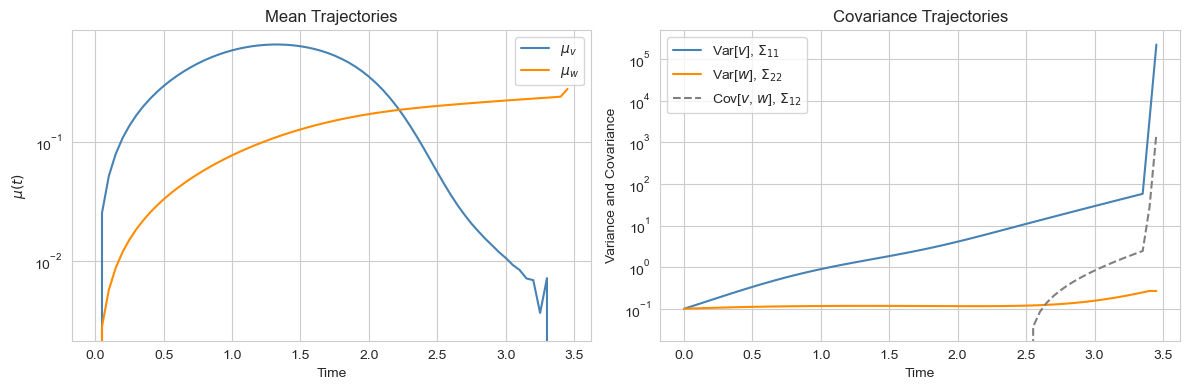

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

def unflatten_trajectory(sol):
    mu1 = sol[0]
    mu2 = sol[1]
    var1 = sol[2]
    cov12 = sol[3]
    var2 = sol[5]
    return mu1, mu2, var1, var2, cov12

mu1, mu2, var1, var2, cov12 = unflatten_trajectory(sol.ys.T)
times = sol.ts

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(times, mu1, label=r'$\mu_v$', color='steelblue')
axes[0].plot(times, mu2, label=r'$\mu_w$', color='darkorange')
axes[0].set_xlabel('Time')
axes[0].set_ylabel(r'$\mu(t)$')
axes[0].set_title('Mean Trajectories')
axes[0].legend()

axes[1].plot(times, var1, label=r'Var[$v$], $\Sigma_{11}$', color='steelblue')
axes[1].plot(times, var2, label=r'Var[$w$], $\Sigma_{22}$', color='darkorange')
axes[1].plot(times, cov12, '--', label=r'Cov[$v$, $w$], $\Sigma_{12}$', color='grey')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Variance and Covariance')
axes[1].set_title('Covariance Trajectories')
axes[1].legend()

axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()